In [1]:
import os
import cv2
import numpy as np
from pathlib import Path
import shutil
import albumentations as A
from tqdm import tqdm

In [2]:
class DatasetAugmenter:
    """Augments a YOLO-format dataset and writes it to a new folder."""
    
    def __init__(self, source_dir, output_dir, augmentations_per_image=4):
        self.source_dir = Path(source_dir)
        self.output_dir = Path(output_dir)
        self.augmentations_per_image = augmentations_per_image
        
        self.transform = A.Compose([
            # Lighting variations
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                A.RandomGamma(gamma_limit=(70, 130)),
                A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8)),
            ], p=0.8),

            # Color variations
            A.HueSaturationValue(15, 30, 20, p=0.7),

            # Blur
            A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.GaussianBlur(blur_limit=(3, 5)),
                A.MedianBlur(blur_limit=5),
            ], p=0.3),

            # Noise
            A.OneOf([
                A.GaussNoise(std_range=(0.1, 0.2), mean_range=(0.0, 0.0), p=1.0),
                A.ISONoise(color_shift=(0.01, 0.08), intensity=(0.1, 0.5), p=1.0),
            ], p=0.3),

            # Geometric transforms
            A.Affine(
                scale=(0.8, 1.2),
                translate_percent=(0.0, 0.1),
                rotate=(-15, 15),
                shear=(-5, 5),
                fit_output=False,
                p=0.7
            ),

            # Horizontal flip
            A.HorizontalFlip(p=0.5),

            # Shadows
            A.RandomShadow(p=0.3),
            
        ], bbox_params=A.BboxParams(
            format='yolo',
            label_fields=['class_labels'],
            min_area=100,
            min_visibility=0.3
        ))
    
    def augment(self):
        self._prepare_dirs()
        for split in ['train', 'val']:
            self._process_split(split)
    
    def _prepare_dirs(self):
        for split in ['train', 'val']:
            (self.output_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
            (self.output_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)
    
    def _process_split(self, split):
        img_dir = self.source_dir / 'images' / split
        label_dir = self.source_dir / 'labels' / split
        if not img_dir.exists(): return
        
        image_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
        print(f"[{split}] Images found: {len(image_files)}")
        
        # Copy originals
        for img_path in tqdm(image_files, desc=f"Copying {split}", leave=False):
            shutil.copy2(img_path, self.output_dir / 'images' / split / img_path.name)
            label_path = label_dir / f"{img_path.stem}.txt"
            if label_path.exists():
                shutil.copy2(label_path, self.output_dir / 'labels' / split / label_path.name)
        
        # Augment only training split
        if split == "train":
            self._augment_images(image_files, label_dir, split)
    
    def _augment_images(self, image_files, label_dir, split):
        for img_path in tqdm(image_files, desc=f"Augmenting {split}", leave=False):
            image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
            label_file = label_dir / f"{img_path.stem}.txt"
            if not label_file.exists(): continue
            
            bboxes, class_labels = [], []
            for line in open(label_file):
                parts = line.strip().split()
                if len(parts) == 5:
                    class_labels.append(int(parts[0]))
                    bboxes.append([float(x) for x in parts[1:]])
            
            for aug_idx in range(self.augmentations_per_image):
                transformed = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
                if not transformed['bboxes']: continue
                
                aug_img = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                aug_name = f"{img_path.stem}_aug{aug_idx}{img_path.suffix}"
                cv2.imwrite(str(self.output_dir / 'images' / split / aug_name), aug_img)
                
                label_path = self.output_dir / 'labels' / split / f"{img_path.stem}_aug{aug_idx}.txt"
                with open(label_path, 'w') as f:
                    for cid, bbox in zip(transformed['class_labels'], transformed['bboxes']):
                        bbox = [max(0, min(1, x)) for x in bbox]
                        f.write(f"{cid} {' '.join(map(str, bbox))}\n")


In [3]:
def summarize(dataset_dir):
    dataset_dir = Path(dataset_dir)
    for split in ['train', 'val']:
        img_dir = dataset_dir / 'images' / split
        if not img_dir.exists(): continue
        count = len(list(img_dir.glob('*')))
        print(f"{split.capitalize():7} images: {count}")

In [4]:
SOURCE = "/kaggle/input/drowsiness-detection-final-data/final_dataset"
OUTPUT = "/kaggle/working/augmented_dataset"
AUG = 4

augmenter = DatasetAugmenter(SOURCE, OUTPUT, AUG)
augmenter.augment()
summarize(OUTPUT)


[train] Images found: 169


[val] Images found: 38


Train   images: 845
Val     images: 38


In [5]:
import random
import matplotlib.pyplot as plt

def show_augmented_samples(original_dir, augmented_dir, num_samples=5):
    """
    Display side-by-side comparison of random original images vs augmented versions
    """
    original_images = list((Path(original_dir) / "images" / "train").glob("*"))
    augmented_images = list((Path(augmented_dir) / "images" / "train").glob("*_aug*"))

    if not augmented_images:
        print("No augmented images found.")
        return
    
    samples = random.sample(augmented_images, min(num_samples, len(augmented_images)))

    for aug_img_path in samples:
        # find corresponding original
        orig_stem = aug_img_path.stem.split("_aug")[0]
        orig_path = Path(original_dir) / "images" / "train" / f"{orig_stem}{aug_img_path.suffix}"

        # read images
        aug = cv2.cvtColor(cv2.imread(str(aug_img_path)), cv2.COLOR_BGR2RGB)
        orig = cv2.cvtColor(cv2.imread(str(orig_path)), cv2.COLOR_BGR2RGB) if orig_path.exists() else None

        plt.figure(figsize=(10,4))
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis("off")
            
        plt.subplot(1, 2, 2)
        plt.imshow(aug)
        plt.title("Augmented")
        plt.axis("off")
        plt.show()

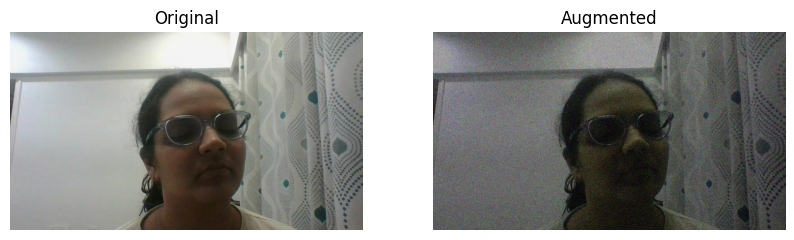

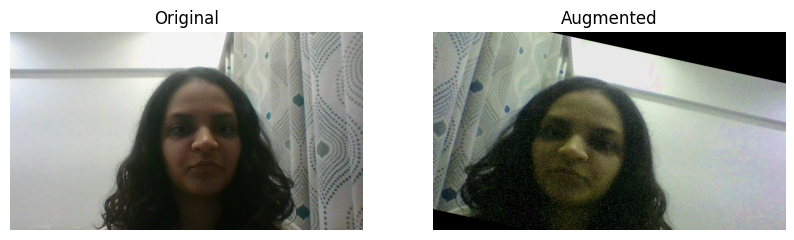

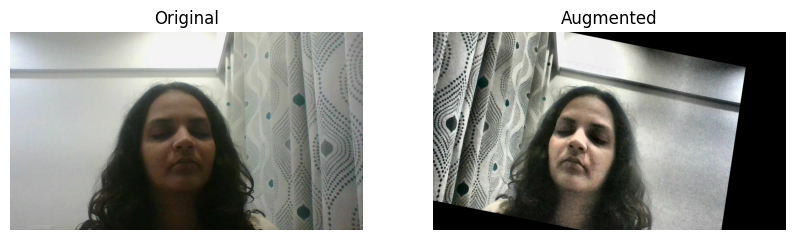

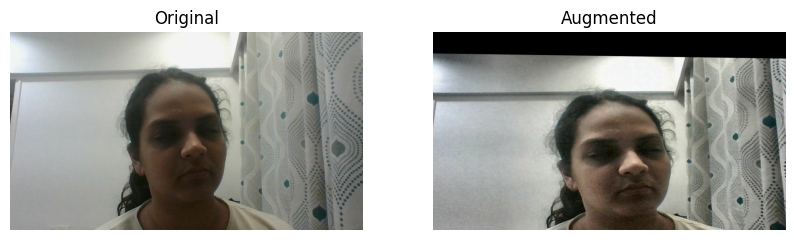

In [6]:
show_augmented_samples(
    original_dir=SOURCE,
    augmented_dir=OUTPUT,
    num_samples=4   
)
